# DT GPU (Modified RF)

In [3]:
# Install required packages
!pip install -q cudf-cu12 cuml-cu12 cupy-cuda12x

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requ

In [1]:
import pandas as pd
df = pd.read_csv("/content/dysnet1.csv")

In [5]:
# check for null values
df.isnull().sum()

,0
mfcc_0,0
mfcc_1,0
mfcc_2,0
mfcc_3,0
mfcc_4,0
mfcc_5,1
mfcc_6,1
mfcc_7,1
mfcc_8,1
mfcc_9,1


In [6]:
# drop all the rows with missing values
df.dropna(inplace=True)

Total parameter combinations: 144

Combination 1/144 at 09:18:29
Parameters: {'max_depth': 5, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2}


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


Training Score: 0.9489
Test Score: 0.9460
Iteration Time: 00:00:00
New best score: 0.9460

Combination 2/144 at 09:18:29
Parameters: {'max_depth': 5, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 5}
Training Score: 0.9489
Test Score: 0.9460
Iteration Time: 00:00:00

Combination 3/144 at 09:18:30
Parameters: {'max_depth': 5, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Training Score: 0.9489
Test Score: 0.9460
Iteration Time: 00:00:00

Combination 4/144 at 09:18:30
Parameters: {'max_depth': 5, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Training Score: 0.9489
Test Score: 0.9461
Iteration Time: 00:00:00
New best score: 0.9461

Combination 5/144 at 09:18:30
Parameters: {'max_depth': 5, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 5}
Training Score: 0.9489
Test Score: 0.9461
Iteration Time: 00:00:00

Combination 6/144 at 09:18:31
Parameters: {'max_depth': 5, 'max_features': 0.3, 'min_samples_leaf': 2, 'm

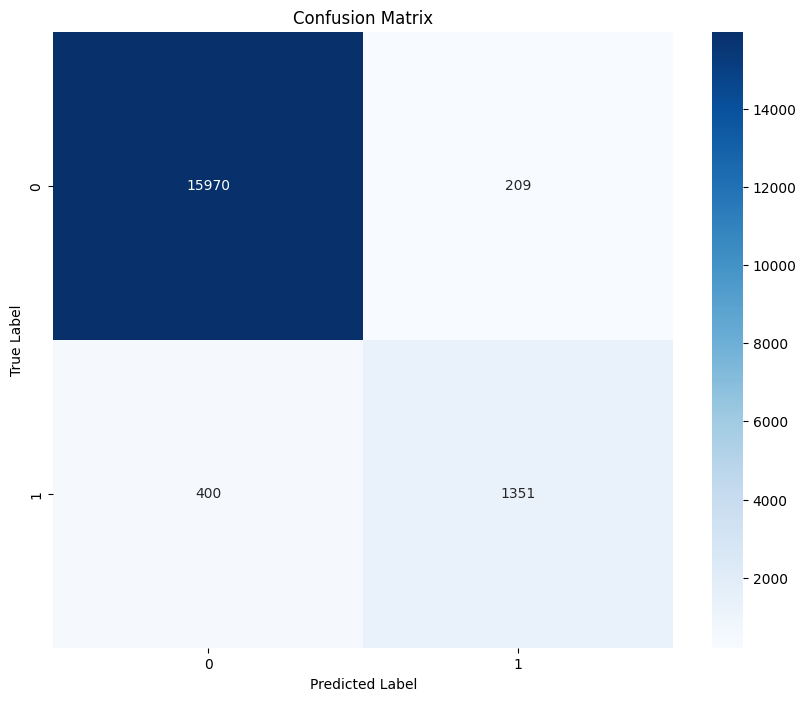

In [9]:
import cudf
import cuml
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.model_selection import ParameterGrid
import numpy as np
import time
import joblib

# Convert pandas DataFrame to cuDF
df_gpu = cudf.DataFrame(df)
X = df_gpu.drop('label', axis=1)
y = df_gpu['label']

# Convert data to float32 for better GPU performance
X = X.astype('float32')
y = y.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data using GPU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for Decision Tree
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.3, 0.5, 0.7, 1.0]
}

# Calculate total combinations
total_combinations = len([p for p in ParameterGrid(param_grid)])
print(f"Total parameter combinations: {total_combinations}")

# Initialize variables
best_score = 0
best_params = None
best_model = None

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Grid search with progress tracking
start_time = time.time()
for i, params in enumerate(ParameterGrid(param_grid), 1):
    iteration_start = time.time()
    current_time = time.strftime('%H:%M:%S')

    print(f"\nCombination {i}/{total_combinations} at {current_time}")
    print(f"Parameters: {params}")

    # Create single tree using RandomForestClassifier
    model = cuRF(
        n_estimators=1,  # Single tree
        bootstrap=False,  # No bootstrap sampling
        random_state=42,
        **params
    )

    model.fit(X_train_scaled, y_train)
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    iteration_time = time.time() - iteration_start

    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"Iteration Time: {format_time(iteration_time)}")

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
total_time = time.time() - start_time
print("\n" + "="*50)
print("Grid Search Completed!")
print(f"Total Time: {format_time(total_time)}")
print(f"Best Parameters: {best_params}")
print(f"Best Training Score: {best_model.score(X_train_scaled, y_train):.4f}")
print(f"Best Test Score: {best_score:.4f}")

# Save the best model
joblib.dump(best_model, 'DT_GPU.pkl')

# Fine-tuning phase
print("\nStarting fine-tuning phase...")

# Create fine-tuning grid based on best parameters
fine_tune_grid = {
    'max_depth': [best_params['max_depth']-2, best_params['max_depth'], best_params['max_depth']+2]
                 if best_params['max_depth'] is not None
                 else [None],
    'min_samples_split': [max(2, best_params['min_samples_split']-1),
                         best_params['min_samples_split'],
                         best_params['min_samples_split']+1],
    'min_samples_leaf': [max(1, best_params['min_samples_leaf']-1),
                        best_params['min_samples_leaf'],
                        best_params['min_samples_leaf']+1],
    'max_features': [best_params['max_features']]
}

# Fine-tuning search
fine_tune_start = time.time()
for i, params in enumerate(ParameterGrid(fine_tune_grid), 1):
    iteration_start = time.time()
    print(f"\nFine-tuning combination {i}/{len(list(ParameterGrid(fine_tune_grid)))}")

    model = cuRF(
        n_estimators=1,
        bootstrap=False,
        random_state=42,
        **params
    )

    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
print("\n" + "="*50)
print("Fine-tuning Completed!")
print(f"Final Best Parameters: {best_params}")
print(f"Final Best Score: {best_score:.4f}")

# Save the final model
joblib.dump(best_model, 'DT_GPU_final.pkl')

# Get predictions and evaluate
y_pred = best_model.predict(X_test_scaled)

# Convert GPU arrays to CPU numpy arrays for evaluation
y_test_cpu = y_test.values.get()
y_pred_cpu = y_pred.values.get()

# Print evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate and print accuracy
accuracy = accuracy_score(y_test_cpu, y_pred_cpu)
print(f"\nAccuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_cpu))

# Create and plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_cpu, y_pred_cpu)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()